# Wild Fires caused by the weather
## Part 4: Machine Learning

In this part, we will use machine learning to verify our research.<br>
The type of machine learning we will use is <b>Supervised Learning</b>.<br>
The label type is <b>Classification Problems</b>.<br>
The Algorithm we will use to predict our findings is <b>Decision Tree</b>.<br>

#### Preceding Step - import modules (packages)
This step is necessary in order to use external packages. 

In [1]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from IPython.display import Image, display  
#!pip install pydotplus
import pydotplus 
from scipy import misc
#!pip install graphviz

#### Global variables and constants
Here we define our global variables we will use in this notebook

In [2]:
FIRE_HISTORY_CSV = "Wildfire_history_final.csv"
NUMERIC_COLS = ['InitialLatitude','InitialLongitude','FireDuration','Temperature', 'MaxTemperature', 'MinTemperature','WindSpeed','WindDirection','Humidity','CausedByWeather']
ALL_FEATURES = ['InitialLatitude','InitialLongitude','FireDuration','Temperature', 'MaxTemperature', 'MinTemperature','WindSpeed','WindDirection','Humidity']
TO_PREDICT_COL = 'CausedByWeather'

### Data Preperation
In this part we will load our final CSV to a data frame. <br>
From the data frame, we will create a new data frame with only relevant columns. <br>
Also, we will implement two functions which will help us in the train and prediction.

In [3]:
df = pd.read_csv(FIRE_HISTORY_CSV)
df.head()

,UniqueFireIdentifier,FireDiscoveryDateTime,FireOutDateTime,POOCounty,InitialLatitude,InitialLongitude,FireCause,FireDuration,CausedByWeather,Temperature,MaxTemperature,MinTemperature,WindSpeed,WindDirection,Humidity
0,2020-MTLG42-000224,2020-08-06T18:58:00,2020-08-12T14:00:00,Carter,45.78496,-104.49580,2,6,0,25.9,34.0,16.5,21.9,206.63,46.67
1,2017-MTNWS-000878,2017-10-17T20:20:24,2017-11-09T21:59:59,Flathead,48.07167,-114.83030,2,23,0,6.1,12.9,-3.3,13.9,119.55,64.20
2,2020-MSMNF-000308,2020-11-23T19:17:00,2020-11-30T14:29:59,Perry,31.06819,-89.06972,2,7,0,10.3,22.7,0.6,11.2,104.88,78.07
3,2019-AZA5S-001664,2019-09-05T19:17:00,2019-09-09T17:00:00,Yavapai,34.40333,-112.43940,1,4,1,24.6,33.1,16.8,11.2,197.58,45.06
4,2020-IDNCF-000071,2020-04-20T21:33:59,2020-04-21T03:00:00,Idaho,45.41833,-116.16610,2,1,0,8.6,15.7,0.7,8.9,195.88,53.81


Now we will create a new data frame with only numeric and relevant columns:

In [4]:
df_copy=df[NUMERIC_COLS].copy()
df_copy.head()

,InitialLatitude,InitialLongitude,FireDuration,Temperature,MaxTemperature,MinTemperature,WindSpeed,WindDirection,Humidity,CausedByWeather
0,45.78496,-104.49580,6,25.9,34.0,16.5,21.9,206.63,46.67,0
1,48.07167,-114.83030,23,6.1,12.9,-3.3,13.9,119.55,64.20,0
2,31.06819,-89.06972,7,10.3,22.7,0.6,11.2,104.88,78.07,0
3,34.40333,-112.43940,4,24.6,33.1,16.8,11.2,197.58,45.06,1
4,45.41833,-116.16610,1,8.6,15.7,0.7,8.9,195.88,53.81,0


standardScale(): Prints the Standard Scale

In [5]:
def standardScale(XTrain, XTest):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(XTrain)
    X_test_scaled = scaler.transform(XTest)
    print("X_train_scaled Mean: ", X_train_scaled.mean(axis=0))
    print("X_train_scaled Standard Deviation: ", X_train_scaled.std(axis=0))
    print("X_test_scaled Mean: ", X_test_scaled.mean(axis=0))
    print("X_test_scaled Standard Deviation: ", X_test_scaled.std(axis=0))

minMaxScale(): Prints the Min Max Scale

In [6]:
def minMaxScale(XTrain, XTest):
    min_max_scaler = MinMaxScaler(feature_range=(0, 1))
    X_train_scaled_in_range = min_max_scaler.fit_transform(XTrain)
    X_test_scaled_in_range = min_max_scaler.transform(XTest)
    print("X_train_scaled_in_range Min Value: ", X_train_scaled_in_range.min(axis=0))
    print("X_train_scaled_in_range Max Value: ", X_train_scaled_in_range.max(axis=0))
    print("X_test_scaled_in_range Min Value: ", X_test_scaled_in_range.min(axis=0))
    print("X_test_scaled_in_range Max Value: ", X_test_scaled_in_range.max(axis=0))

splitData(): Getting array of features and splitting the data to train and test

In [7]:
def splitData(features):
    X = df_copy[features].values
    y = df_copy[TO_PREDICT_COL].values

    # Split into training and test sets
    XTrain, XTest, yTrain, yTest = train_test_split(X, y, random_state=1, test_size=0.2)
    
    print("Initial amount of samples: #{}".format(X.shape[0]))
    print("Number of training samples: #{}".format(XTrain.shape[0]))
    print("Number of test samples: #{}".format(XTest.shape[0]))
    print("")
    print("Standard Scale:")
    standardScale(XTrain, XTest)
    print("")
    print("MinMax Scale:")
    minMaxScale(XTrain, XTest)
    print("")

    return XTrain, XTest, yTrain, yTest

renderTree(): Creates image of the decision tree

In [8]:
def renderTree(my_tree, features):
    # hacky solution of writing to files and reading again
    # necessary due to library bugs
    filename = "temp.dot"
    with open(filename, 'w') as f:
        f = tree.export_graphviz(my_tree, 
                                 out_file=f, 
                                 feature_names=features, 
                                 class_names=["Not nature", "Nature"],  
                                 filled=True, 
                                 rounded=True,
                                 special_characters=True)
  
    dot_data = ""
    with open(filename, 'r') as f:
        dot_data = f.read()

    graph = pydotplus.graph_from_dot_data(dot_data)
    image_name = "temp.png"
    graph.write_png(image_name)  
    display(Image(filename=image_name))

### Applying the Algorithm
In this part, we will run the decision tree algorithm on different variations of the dataframe featues

runDecisionTree(): Getting a features and running the decision tree algorithm

In [9]:
def runDecisionTree(features, maxd):
    decisionTree = tree.DecisionTreeClassifier(max_depth=maxd, min_samples_split=20)

    XTrain, XTest, yTrain, yTest = splitData(features)
    # fit the tree with the traing data
    decisionTree = decisionTree.fit(XTrain, yTrain)

    # predict with the training data
    y_pred_train = decisionTree.predict(XTrain)
    # measure accuracy
    print('Accuracy on training data = ', 
          metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

    # predict with the test data
    y_pred = decisionTree.predict(XTest)
    # measure accuracy
    print('Accuracy on test data = ', 
          metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

    renderTree(decisionTree, features)

Initial amount of samples: #42759
Number of training samples: #34207
Number of test samples: #8552

Standard Scale:
X_train_scaled Mean:  [-3.308956e-16]
X_train_scaled Standard Deviation:  [1.]
X_test_scaled Mean:  [0.00498363]
X_test_scaled Standard Deviation:  [1.00590762]

MinMax Scale:
X_train_scaled_in_range Min Value:  [0.]
X_train_scaled_in_range Max Value:  [1.]
X_test_scaled_in_range Min Value:  [0.00257732]
X_test_scaled_in_range Max Value:  [0.98195876]

Accuracy on training data =  0.6568830941035461
Accuracy on test data =  0.6551683816651076


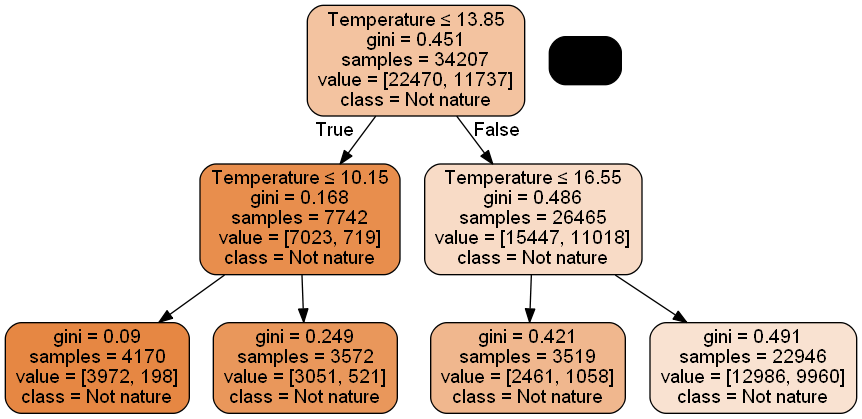

In [10]:
runDecisionTree(["Temperature"], 2)

Initial amount of samples: #42759
Number of training samples: #34207
Number of test samples: #8552

Standard Scale:
X_train_scaled Mean:  [ 6.80998671e-16 -7.33017879e-15  1.07725550e-14]
X_train_scaled Standard Deviation:  [1. 1. 1.]
X_test_scaled Mean:  [ 0.00498363  0.00205392 -0.00258526]
X_test_scaled Standard Deviation:  [1.00590762 1.00709897 0.99046764]

MinMax Scale:
X_train_scaled_in_range Min Value:  [0. 0. 0.]
X_train_scaled_in_range Max Value:  [1. 1. 1.]
X_test_scaled_in_range Min Value:  [0.00257732 0.05923345 0.01317578]
X_test_scaled_in_range Max Value:  [0.98195876 1.         0.99247098]

Accuracy on training data =  0.6717338556435817
Accuracy on test data =  0.6752806361085126


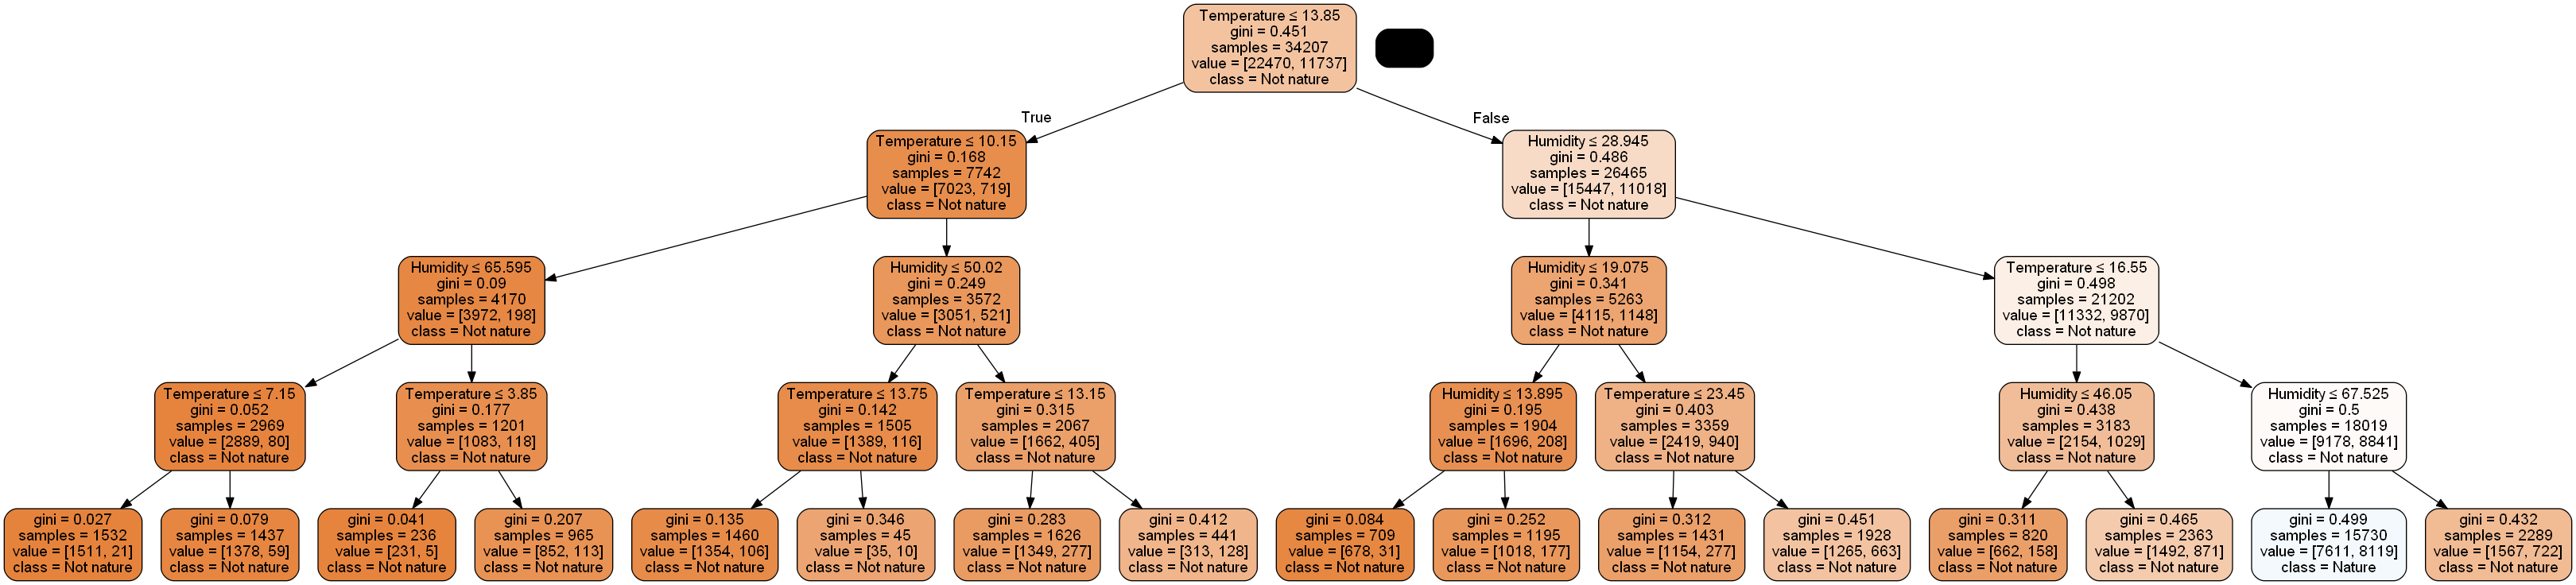

In [11]:
runDecisionTree(["Temperature", "WindSpeed", "Humidity"], 4)

Initial amount of samples: #42759
Number of training samples: #34207
Number of test samples: #8552

Standard Scale:
X_train_scaled Mean:  [ 3.37346233e-14  8.16585960e-15  1.33689586e-16  6.80998671e-16
  9.72036982e-15 -8.82487809e-14 -7.33017879e-15  2.17302628e-13
  1.07725550e-14]
X_train_scaled Standard Deviation:  [1. 1. 1. 1. 1. 1. 1. 1. 1.]
X_test_scaled Mean:  [ 3.68666806e-05 -4.77232707e-03  2.83074972e-02  4.98362875e-03
  1.99951018e-03  9.38913701e-03  2.05392009e-03 -8.93930570e-03
 -2.58525684e-03]
X_test_scaled Standard Deviation:  [0.99941715 1.0141077  1.01900024 1.00590762 1.01339049 0.99587841
 1.00709897 0.9904357  0.99046764]

MinMax Scale:
X_train_scaled_in_range Min Value:  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
X_train_scaled_in_range Max Value:  [1. 1. 1. 1. 1. 1. 1. 1. 1.]
X_test_scaled_in_range Min Value:  [0.0050433  0.02298946 0.         0.00257732 0.         0.
 0.05923345 0.00179922 0.01317578]
X_test_scaled_in_range Max Value:  [0.99736627 0.9434093  1.         

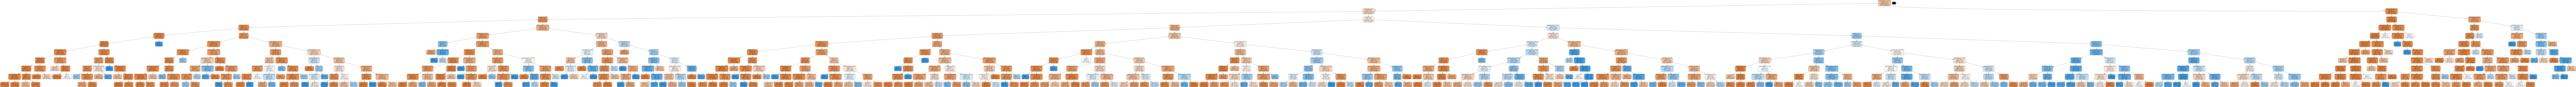

In [12]:
runDecisionTree(ALL_FEATURES, 10)

### Random Forest
In this part, we will run a Random Forest algorithm

In [13]:
XTrain, XTest, yTrain, yTest = splitData(ALL_FEATURES)

forest =  RandomForestClassifier(bootstrap=True, n_estimators=300, random_state=0)

trained_forest = forest.fit(XTrain, yTrain) 

y_pred_train = trained_forest.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = trained_forest.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

Initial amount of samples: #42759
Number of training samples: #34207
Number of test samples: #8552

Standard Scale:
X_train_scaled Mean:  [ 3.37346233e-14  8.16585960e-15  1.33689586e-16  6.80998671e-16
  9.72036982e-15 -8.82487809e-14 -7.33017879e-15  2.17302628e-13
  1.07725550e-14]
X_train_scaled Standard Deviation:  [1. 1. 1. 1. 1. 1. 1. 1. 1.]
X_test_scaled Mean:  [ 3.68666806e-05 -4.77232707e-03  2.83074972e-02  4.98362875e-03
  1.99951018e-03  9.38913701e-03  2.05392009e-03 -8.93930570e-03
 -2.58525684e-03]
X_test_scaled Standard Deviation:  [0.99941715 1.0141077  1.01900024 1.00590762 1.01339049 0.99587841
 1.00709897 0.9904357  0.99046764]

MinMax Scale:
X_train_scaled_in_range Min Value:  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
X_train_scaled_in_range Max Value:  [1. 1. 1. 1. 1. 1. 1. 1. 1.]
X_test_scaled_in_range Min Value:  [0.0050433  0.02298946 0.         0.00257732 0.         0.
 0.05923345 0.00179922 0.01317578]
X_test_scaled_in_range Max Value:  [0.99736627 0.9434093  1.         

In [14]:
featuresDF=pd.DataFrame({"features":ALL_FEATURES,"weights":trained_forest.feature_importances_})
featuresDF.sort_values("weights",ascending=False)

,features,weights
1,InitialLongitude,0.225414
0,InitialLatitude,0.158176
8,Humidity,0.148466
3,Temperature,0.102428
5,MinTemperature,0.096859
4,MaxTemperature,0.083436
7,WindDirection,0.073283
6,WindSpeed,0.065935
2,FireDuration,0.046004
